## Import packages & set-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingClassifier

[nltk_data] Downloading package punkt to /Users/edwin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/edwin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/edwin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/edwin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Processing dataframe

In [2]:
df = pd.read_csv('bt4222_dataset_21.csv')

In [3]:
df.columns

Index(['app_id', 'app_name', 'review_id', 'review', 'timestamp_updated',
       'recommended', 'author.steamid', 'author.num_games_owned',
       'author.playtime_at_review', 'Release date', 'Required age', 'Price',
       'DLC count', 'About the game', 'Windows', 'Mac', 'Linux', 'Genres',
       'Categories', 'Developers', 'Publishers', 'is_free', 'owned_games',
       'weighted_vote_score', 'votes_helpful', 'user_review_count',
       'item_review_count', 'game_playtime_percentile', 'game_description',
       'review_text_clean', 'pred_rating'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126144 entries, 0 to 126143
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   app_id                     126144 non-null  int64  
 1   app_name                   126144 non-null  object 
 2   review_id                  126144 non-null  int64  
 3   review                     126144 non-null  object 
 4   timestamp_updated          126144 non-null  int64  
 5   recommended                126144 non-null  bool   
 6   author.steamid             126144 non-null  int64  
 7   author.num_games_owned     126144 non-null  int64  
 8   author.playtime_at_review  126144 non-null  float64
 9   Release date               126144 non-null  object 
 10  Required age               126144 non-null  int64  
 11  Price                      126144 non-null  float64
 12  DLC count                  126144 non-null  int64  
 13  About the game             12

### Check if every user only has at most 1 interaction with any unique game

In [5]:
# Group by 'author.steamid' and 'app_id' and count the interactions
interaction_counts = df.groupby(['author.steamid', 'app_id']).size().reset_index(name='interaction_count')

# Check if there are any pairs with interaction_count greater than 1
has_multiple_interactions = interaction_counts['interaction_count'].gt(1).any()

if has_multiple_interactions:
    print("There are some author.steamid values with multiple interactions for the same app_id.")
else:
    print("Each author.steamid has only one interaction with each app_id.")


Each author.steamid has only one interaction with each app_id.


In [6]:
df['author.steamid'].nunique()

4935

In [7]:
df['author.playtime_at_review'].describe()

count    1.261440e+05
mean     4.039642e+03
std      1.692714e+04
min      1.000000e+00
25%      3.410000e+02
50%      9.980000e+02
75%      3.006000e+03
max      1.847147e+06
Name: author.playtime_at_review, dtype: float64

### Process game description for TF-IDF calculations

In [8]:
def process_text(text):
    text_lower = text.lower()
    tokens = word_tokenize(text_lower)

    # filter Alphabetic Tokens
    alphabetic_tokens = [word for word in tokens if re.match('^[a-zA-Z]+$', word)]

    # remove stopwords and preserve negation words
    stop_words = set(stopwords.words('english'))
    negation_words = ['not', 'no', 'never', "n't", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't",
                      "doesn't", "don't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "mustn't", "can't", "cannot"]
    tokens_no_stopwords = [word for word in alphabetic_tokens]

    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens_no_stopwords]
    processed_text = ' '.join(lemmatized_words)

    return processed_text

In [9]:
df['processed_description'] = df['game_description'].apply(process_text)

In [10]:
sample_text = df.loc[0, 'processed_description']
sample_text

'casual indie simulation pvp online pvp lan pvp online lan multiplayer steam achievement steam trading card caption available steam workshop steam cloud valve enabled includes level editor includes source sdk remote play on tablet family sharing garry mod is a physic sandbox there are any predefined aim or goal we give you the tool and leave you to play you spawn object and weld them together to create your own contraption whether that a car a rocket a catapult or something that doe have a name yet that up to you you can do it offline or join the thousand of player who play online each day if you not too great at construction do worry you can place a variety of character in silly position but if you want to do more we have the mean beyond the sandbox the garry mod community is a tremendous source of content and ha added hundred of unique mode to the game in trouble in terrorist town you can be a detective solving an online murder a criminal attempt to cover up their homicide be a ball 

### Check distribution and outliers for numerical features to determine what kind of scaling to use

weighted_vote_score - Number of outliers: 0
author.playtime_at_review - Number of outliers: 15112
Price - Number of outliers: 9891
DLC count - Number of outliers: 13084
Required age - Number of outliers: 0
item_review_count - Number of outliers: 0
pred_rating - Number of outliers: 21879


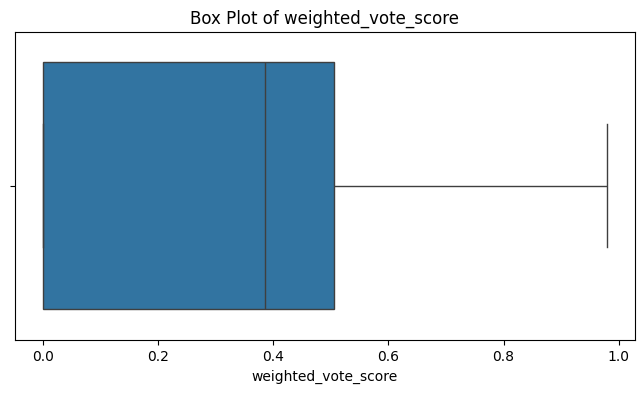

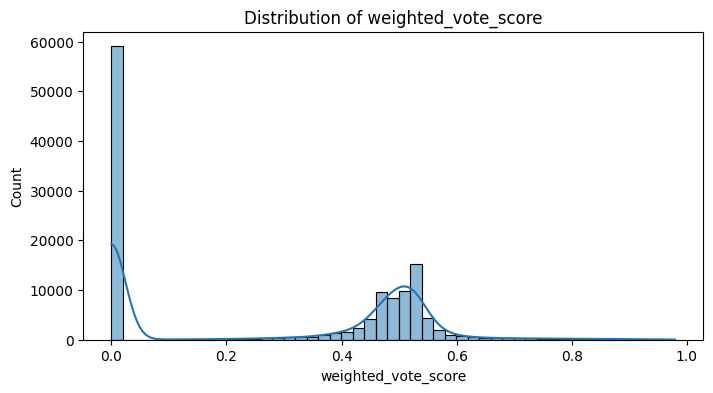

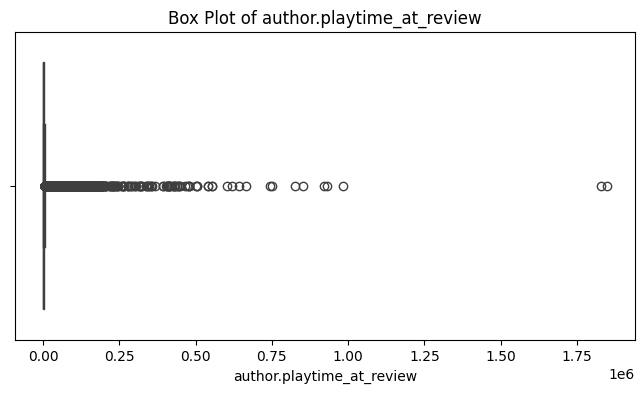

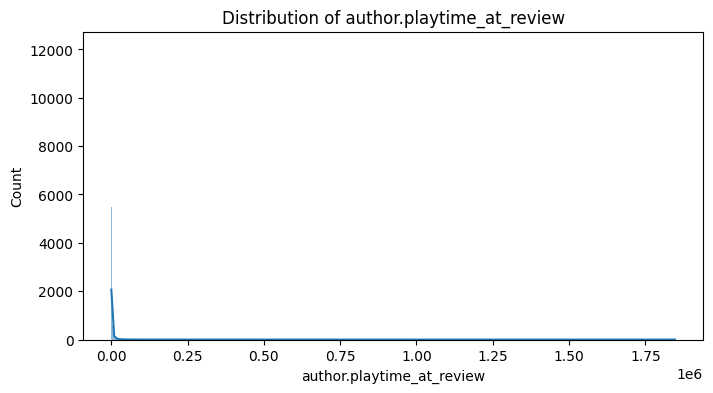

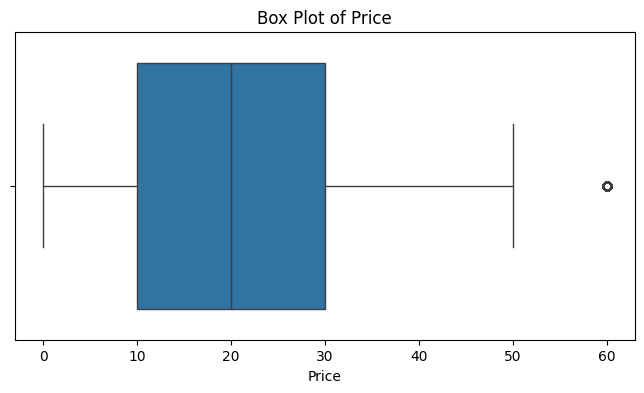

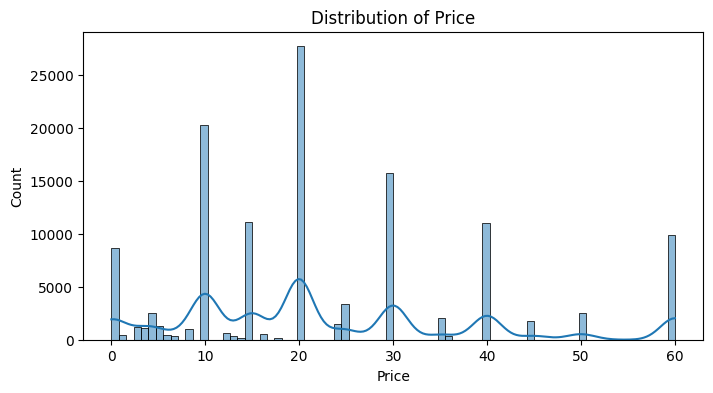

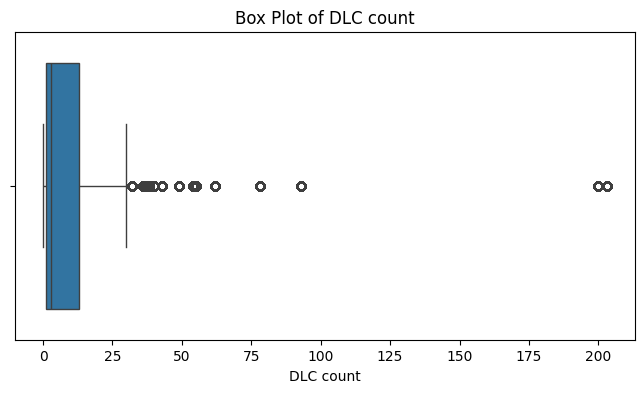

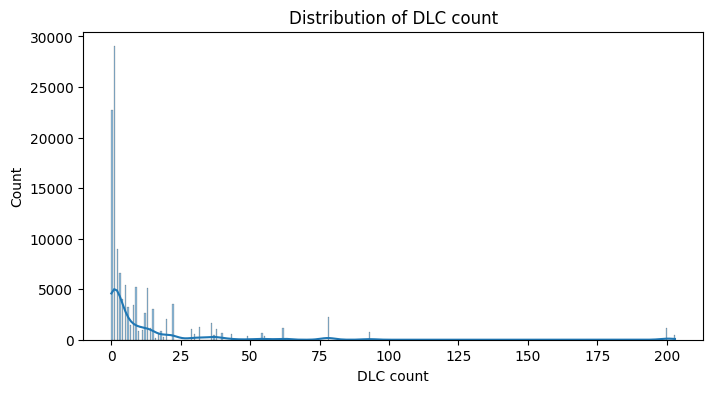

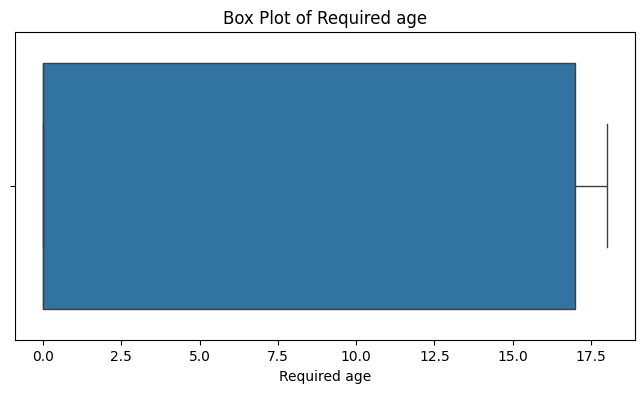

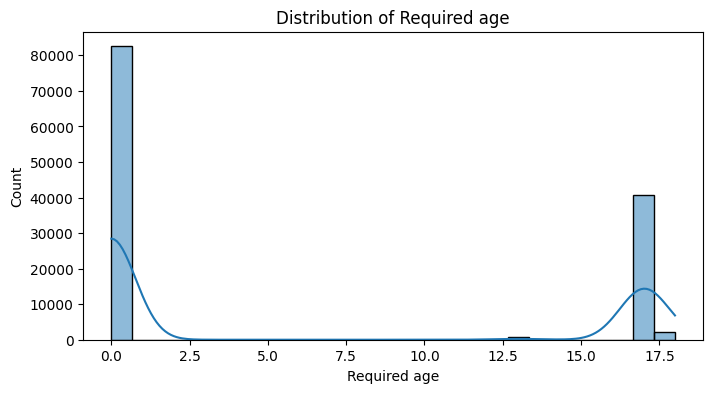

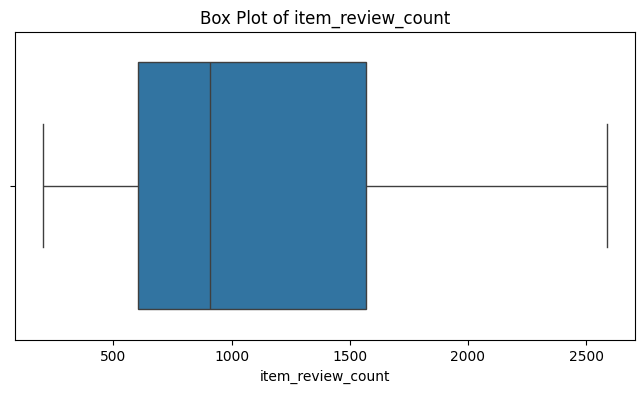

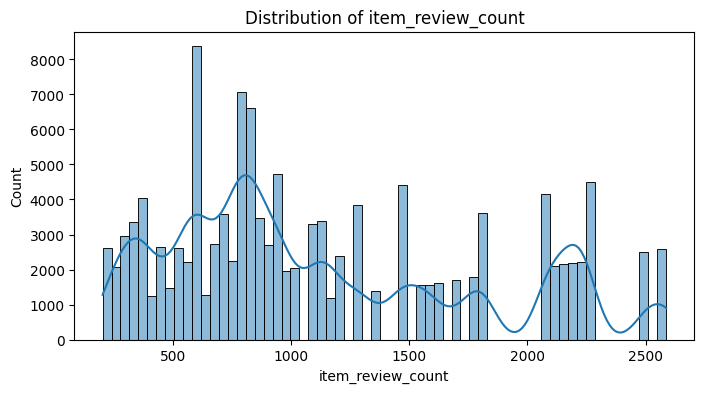

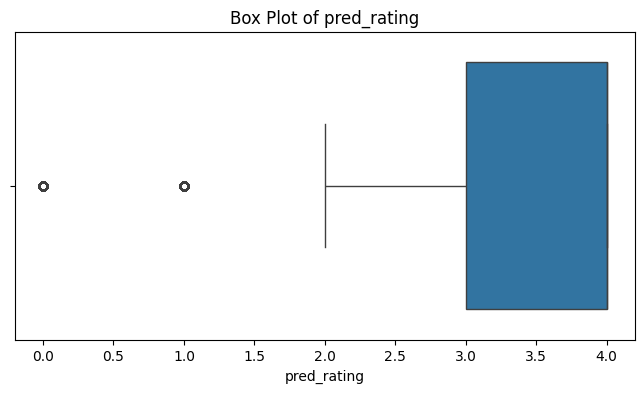

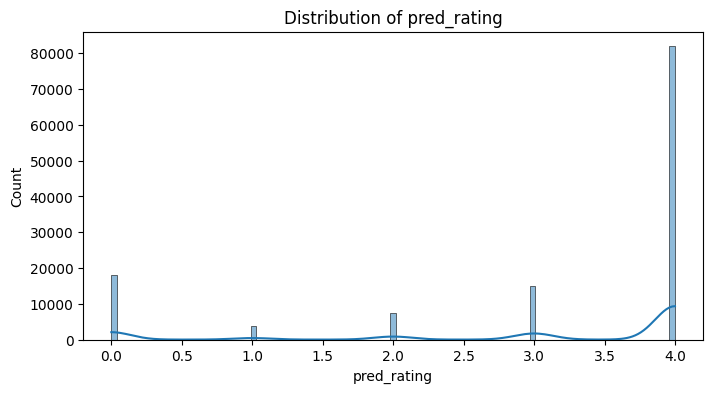

          weighted_vote_score  author.playtime_at_review     Price  DLC count  \
skew                 0.044787                  37.484821  0.806551   4.926889   
kurtosis            -1.724544                2804.205923  0.023817  29.096550   

          Required age  item_review_count  pred_rating  
skew          0.652523           0.660614    -1.358306  
kurtosis     -1.569439          -0.721649     0.226621  


In [11]:
# calculate IQR and detect outliers for each numerical feature
for feature in ['weighted_vote_score', 'author.playtime_at_review', 'Price', 'DLC count', 'Required age', 'item_review_count', 'pred_rating']:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR))).sum()
    print(f"{feature} - Number of outliers: {outliers}")

for feature in ['weighted_vote_score', 'author.playtime_at_review', 'Price', 'DLC count', 'Required age', 'item_review_count', 'pred_rating']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature])
    plt.title(f"Box Plot of {feature}")
    plt.show()
    
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature}")
    plt.show()

# calculate skewness and kurtosis
skew_kurt_df = df[['weighted_vote_score', 'author.playtime_at_review', 'Price', 'DLC count', 'Required age', 'item_review_count', 'pred_rating']].agg(['skew', 'kurtosis'])
print(skew_kurt_df)

In [12]:
# scale all the numerical features in df for model input

scaler_df = StandardScaler()
df_cluster_columns = df[['weighted_vote_score', 'author.playtime_at_review', 
                                   'Price', 'DLC count', 'Required age', 'item_review_count', 'pred_rating']]
scaled_values = scaler_df.fit_transform(df_cluster_columns)
df[['weighted_vote_score', 'author.playtime_at_review', 
                                   'Price', 'DLC count', 'Required age', 'item_review_count', 'pred_rating']] = scaled_values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126144 entries, 0 to 126143
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   app_id                     126144 non-null  int64  
 1   app_name                   126144 non-null  object 
 2   review_id                  126144 non-null  int64  
 3   review                     126144 non-null  object 
 4   timestamp_updated          126144 non-null  int64  
 5   recommended                126144 non-null  bool   
 6   author.steamid             126144 non-null  int64  
 7   author.num_games_owned     126144 non-null  int64  
 8   author.playtime_at_review  126144 non-null  float64
 9   Release date               126144 non-null  object 
 10  Required age               126144 non-null  float64
 11  Price                      126144 non-null  float64
 12  DLC count                  126144 non-null  float64
 13  About the game             12

## Train-Test Split

In [13]:
# ensure chronological order in time-test split
df_modelling = df.sort_values(by=['author.steamid', 'timestamp_updated']).reset_index(drop=True)

split = 0.8

# unique user IDs
unique_users = df_modelling['author.steamid'].unique()

# store training and test data
train_data = []
test_data = []

# split data for each user
for user_id in unique_users:
    user_data = df_modelling[df_modelling['author.steamid'] == user_id]
    split_idx = round(len(user_data) * split)
    train_data.append(user_data.iloc[:split_idx])
    test_data.append(user_data.iloc[split_idx:])

train = pd.concat(train_data)
test = pd.concat(test_data)

# Filter test set to include only items present in the train set
test = test[test["app_id"].isin(train['app_id'])]

print(train.shape)
print(test.shape)


(101072, 32)
(25072, 32)


## Logistic Regression for Numerical Features

In [14]:
# prepare training data for numerical attributes
X_train = train[['weighted_vote_score', 'author.playtime_at_review', 'Price', 'DLC count', 'Required age', 'item_review_count', 'pred_rating']]
y_train = train[['recommended']]

print(X_train.shape)
print(y_train.shape)

# prepare test data
X_test = test[['weighted_vote_score', 'author.playtime_at_review', 'Price', 'DLC count', 'Required age', 'item_review_count', 'pred_rating']]
y_test = test[['author.steamid', 'app_id', 'recommended']]  # Keep all details for evaluation

(101072, 7)
(101072, 1)


### Model training

In [15]:
logreg_numerical_features = LogisticRegression()
logreg_numerical_features.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

### Model evaluation - F1 score, Recall, Precision and NDCG where @ K = 4

In [ ]:
K = 4

precision_at_k_list = []
recall_at_k_list = []
f1_at_k_list = []
ndcg_at_k_list = []

total_users = len(y_test['author.steamid'].unique())

# for each user in the test set
for i, user_id in enumerate(y_test['author.steamid'].unique(), start=1):
    
    # get the games the user has interacted with in the test set
    user_test_games = y_test[y_test['author.steamid'] == user_id]['app_id'].values
    
    # get all games not interacted by this user in training and test 
    # (since both sets are filtered to ensure no games are in one but not the other) 
    # set for recommendation
    user_train_games = train[train['author.steamid'] == user_id]['app_id'].values
    all_games = df[['app_id', 'weighted_vote_score', 'author.playtime_at_review', 'Price', 'DLC count', 'Required age', 'item_review_count', 'pred_rating']].drop_duplicates()
    
    # aggregate the numeric features per game
    all_games_aggregated = all_games.groupby('app_id', as_index=False).mean()
    unseen_games_df = all_games_aggregated[~all_games_aggregated['app_id'].isin(user_train_games)]
    
    if unseen_games_df.empty:
        continue
    
    # extract unseen game features
    unseen_features = unseen_games_df[['weighted_vote_score', 'author.playtime_at_review', 'Price', 'DLC count', 'Required age', 'item_review_count', 'pred_rating']]
    
    # predict probabilities for each unseen game
    unseen_probabilities = logreg_numerical_features.predict_proba(unseen_features)[:, 1]

    # pair each probability with its corresponding unseen game index
    prob_with_index = list(enumerate(unseen_probabilities))
    
    # rank by probability and retrieve top K indices
    actual_k = min(K, len(unseen_probabilities)) 
    top_k_indices = [idx for idx, prob in sorted(prob_with_index, key=lambda x: x[1], reverse=True)[:actual_k]]
    top_k_recommendations = unseen_games_df.iloc[top_k_indices]['app_id'].tolist()
    
    # precision@K for this user
    relevant_recommendations = [game for game in top_k_recommendations if game in user_test_games] # user has interacted with it before; will take it as 'recommended'
    precision_at_k = len(relevant_recommendations) / actual_k
    precision_at_k_list.append(precision_at_k)
    
    # recall@K for this user
    recall_at_k = len(relevant_recommendations) / len(user_test_games)
    recall_at_k_list.append(recall_at_k)
    
    # f1@K for this user
    if precision_at_k + recall_at_k > 0:
        f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)
    else:
        f1_at_k = 0
    f1_at_k_list.append(f1_at_k)

    # NDCG@K
    dcg = sum([1 / np.log2(idx + 2) for idx, item in enumerate(top_k_recommendations) if item in user_test_games])
    idcg = sum([1 / np.log2(idx + 2) for idx in range(min(len(user_test_games), K))])
    ndcg_at_k = dcg / idcg if idcg > 0 else 0
    ndcg_at_k_list.append(ndcg_at_k)


# average Precision@K, Recall@K, and F1@K across all users
average_precision_at_k = np.mean(precision_at_k_list)
average_recall_at_k = np.mean(recall_at_k_list)
average_f1_at_k = np.mean(f1_at_k_list)
average_ndcg_at_k = np.mean(ndcg_at_k_list)

print(f"Average Precision@K: {average_precision_at_k}")
print(f"Average Recall@K: {average_recall_at_k}")
print(f"Average F1@K: {average_f1_at_k}")
print(f"Average NDCG@K: {average_ndcg_at_k}")

Total users to evaluate: 4935

Evaluating for user 1/4935 (User ID: 76561197960270613)
actual: 
150
recommendations: [519860, 1145360, 960090, 1057090]

Evaluating for user 2/4935 (User ID: 76561197960271994)
actual: 
123
recommendations: [519860, 1145360, 960090, 1057090]

Evaluating for user 3/4935 (User ID: 76561197960319772)
actual: 
146
recommendations: [519860, 1145360, 960090, 1057090]

Evaluating for user 4/4935 (User ID: 76561197960373660)
actual: 
136
recommendations: [519860, 1145360, 960090, 1057090]

Evaluating for user 5/4935 (User ID: 76561197960396581)
actual: 
143
recommendations: [519860, 1145360, 960090, 1057090]

Evaluating for user 6/4935 (User ID: 76561197960407758)
actual: 
148
recommendations: [519860, 1145360, 960090, 1057090]

Evaluating for user 7/4935 (User ID: 76561197960420790)
actual: 
144
recommendations: [519860, 1145360, 960090, 1057090]

Evaluating for user 8/4935 (User ID: 76561197960451002)
actual: 
150
recommendations: [1145360, 960090, 1057090, 54

## Logistic Regression for TFIDF Features

In [ ]:
# convert X_train to a Series (not a DataFrame)
X_train = train['processed_description']
y_train = train['recommended']

# prepare test data
X_test = test['processed_description']
y_test = test[['author.steamid', 'app_id', 'recommended']]

In [18]:
# transform the training data
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)  

### Model training

In [19]:
logreg_tfidf = LogisticRegression()
logreg_tfidf.fit(X_train_tfidf, y_train)

LogisticRegression()

### Model evaluation - F1 score, Recall, Precision and NDCG where @ K = 4

In [20]:
K = 4

precision_at_k_list = []
recall_at_k_list = []
f1_at_k_list = []

total_users = len(y_test['author.steamid'].unique())

# for each user in the test set
for i, user_id in enumerate(y_test['author.steamid'].unique(), start=1):
    
    # get the games the user has interacted with in the test set
    user_test_games = y_test[y_test['author.steamid'] == user_id]['app_id'].values
    
    # get all games not interacted by this user in training for recommendation
    user_train_games = train[train['author.steamid'] == user_id]['app_id'].values
    all_games = df[['app_id', 'processed_description']].drop_duplicates()
    unseen_games_df = all_games[~all_games['app_id'].isin(user_train_games)]
    
    if unseen_games_df.empty:
        continue
    
    # transform unseen game descriptions
    unseen_descriptions = unseen_games_df['processed_description']
    unseen_tfidf = tfidf_vectorizer.transform(unseen_descriptions)
    
    # predict probabilities for each unseen game
    unseen_probabilities = logreg_tfidf.predict_proba(unseen_tfidf)[:, 1]

    # pair each probability with its corresponding unseen game index
    prob_with_index = list(enumerate(unseen_probabilities))
    
    # rank by probability and retrieve top K indices
    actual_k = min(K, len(unseen_probabilities))  # adjust K if fewer than K games
    top_k_indices = [idx for idx, prob in sorted(prob_with_index, key=lambda x: x[1], reverse=True)[:actual_k]]
    top_k_recommendations = unseen_games_df.iloc[top_k_indices]['app_id'].tolist()
    
    # precision@K for this user
    relevant_recommendations = [game for game in top_k_recommendations if game in user_test_games]
    precision_at_k = len(relevant_recommendations) / actual_k
    precision_at_k_list.append(precision_at_k)
    
    # recall@K for this user
    recall_at_k = len(relevant_recommendations) / len(user_test_games)
    recall_at_k_list.append(recall_at_k)
    
    # f1@K for this user
    if precision_at_k + recall_at_k > 0:
        f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)
    else:
        f1_at_k = 0
    f1_at_k_list.append(f1_at_k)

    # NDCG@K
    dcg = sum([1 / np.log2(idx + 2) for idx, item in enumerate(top_k_recommendations) if item in user_test_games])
    idcg = sum([1 / np.log2(idx + 2) for idx in range(min(len(user_test_games), K))])
    ndcg_at_k = dcg / idcg if idcg > 0 else 0
    ndcg_at_k_list.append(ndcg_at_k)

# average Precision@K, Recall@K, and F1@K across all users
average_precision_at_k = np.mean(precision_at_k_list)
average_recall_at_k = np.mean(recall_at_k_list)
average_f1_at_k = np.mean(f1_at_k_list)
average_ndcg_at_k = np.mean(ndcg_at_k_list)

print(f"Average Precision@K: {average_precision_at_k}")
print(f"Average Recall@K: {average_recall_at_k}")
print(f"Average F1@K: {average_f1_at_k}")
print(f"Average NDCG@K: {average_ndcg_at_k}")


Evaluating for user 1/4935 (User ID: 76561197960270613)

Evaluating for user 2/4935 (User ID: 76561197960271994)

Evaluating for user 3/4935 (User ID: 76561197960319772)

Evaluating for user 4/4935 (User ID: 76561197960373660)

Evaluating for user 5/4935 (User ID: 76561197960396581)

Evaluating for user 6/4935 (User ID: 76561197960407758)

Evaluating for user 7/4935 (User ID: 76561197960420790)

Evaluating for user 8/4935 (User ID: 76561197960451002)

Evaluating for user 9/4935 (User ID: 76561197960458629)

Evaluating for user 10/4935 (User ID: 76561197960478145)

Evaluating for user 11/4935 (User ID: 76561197960482833)

Evaluating for user 12/4935 (User ID: 76561197960522414)

Evaluating for user 13/4935 (User ID: 76561197960550140)

Evaluating for user 14/4935 (User ID: 76561197960579974)

Evaluating for user 15/4935 (User ID: 76561197960642654)

Evaluating for user 16/4935 (User ID: 76561197960675266)

Evaluating for user 17/4935 (User ID: 76561197960743698)

Evaluating for user 18

## Stacking Both Models

In [21]:
# prepare training data for numerical attributes and TFIDF
X_train = train[['processed_description', 'weighted_vote_score', 'author.playtime_at_review', 'Price', 'DLC count', 'Required age', 'item_review_count']]
y_train = train[['recommended']]

print(X_train.shape)
print(y_train.shape)

# prepare test data
X_test = test[['processed_description', 'weighted_vote_score', 'author.playtime_at_review', 'Price', 'DLC count', 'Required age', 'item_review_count']]
y_test = test[['author.steamid', 'app_id', 'recommended']] 

# prep the training and test data for input into stacking classifier
X_train_combined = X_train.copy()
X_test_combined = X_test.copy()
y_train = y_train.squeeze()

(101072, 7)
(101072, 1)


### Model Generation

In [22]:
text_column = 'processed_description'
numerical_columns = ['weighted_vote_score', 'author.playtime_at_review', 'Price', 'DLC count', 'Required age', 'item_review_count']

# ColumnTransformer to preprocess each type of data
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(stop_words='english'), text_column),  # apply TF-IDF to the text column
        ('numerical', 'passthrough', numerical_columns)                # pass through numerical columns
    ]
)

# pipeline for the TF-IDF + Logistic Regression model
tfidf_pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('logreg', LogisticRegression())
])

# pipeline for the numerical features + Logistic Regression model
numerical_pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('logreg', LogisticRegression())
])

# stacking classifier with both models
stacking_clf = StackingClassifier(
    estimators=[
        ('tfidf_logreg', tfidf_pipeline),
        ('numerical_logreg', numerical_pipeline)
    ],
    final_estimator=LogisticRegression(), 
    cv=5
)

### Model Training

In [23]:
stacking_clf.fit(X_train_combined, y_train)

StackingClassifier(cv=5,
                   estimators=[('tfidf_logreg',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('tfidf',
                                                                                  TfidfVectorizer(stop_words='english'),
                                                                                  'processed_description'),
                                                                                 ('numerical',
                                                                                  'passthrough',
                                                                                  ['weighted_vote_score',
                                                                                   'author.playtime_at_review',
                                                                                   'Price',
                                                                                   'DLC '
                                                                                   'count',
                                                                                   'Required '
                                                                                   'age',
                                                                                   'item_review_count'])])),
                                                ('logreg',
                                                 LogisticRegr...
                               ('numerical_logreg',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('tfidf',
                                                                                  TfidfVectorizer(stop_words='english'),
                                                                                  'processed_description'),
                                                                                 ('numerical',
                                                                                  'passthrough',
                                                                                  ['weighted_vote_score',
                                                                                   'author.playtime_at_review',
                                                                                   'Price',
                                                                                   'DLC '
                                                                                   'count',
                                                                                   'Required '
                                                                                   'age',
                                                                                   'item_review_count'])])),
                                                ('logreg',
                                                 LogisticRegression())]))],
                   final_estimator=LogisticRegression())

### Model evaluation - F1 score, Recall, Precision and NDCG where @ K = 4

In [ ]:
K = 4

precision_at_k_list = []
recall_at_k_list = []
f1_at_k_list = []
ndcg_at_k_list = []

for i, user_id in enumerate(y_test['author.steamid'].unique(), start=1):
    user_train_games = y_test[y_test['author.steamid'] == user_id]['app_id'].values

    user_train_games = train[train['author.steamid'] == user_id]['app_id'].values
    all_games = df.groupby('app_id').agg({
        'processed_description': 'first',  # take the first description for each game
        'weighted_vote_score': 'mean',     # aggregate the numeric features like before
        'author.playtime_at_review': 'mean',
        'Price': 'mean',
        'DLC count': 'mean',
        'Required age': 'mean',
        'item_review_count': 'mean',
        'pred_rating': 'mean'
    }).reset_index()

    unseen_games_df = all_games[~all_games['app_id'].isin(user_train_games)]
    print(f'unseen games for user:{user_id} is {len(unseen_games_df)}')

    if unseen_games_df.empty:
        continue
    
    unseen_features = unseen_games_df[['processed_description', 'weighted_vote_score', 'author.playtime_at_review', 'Price', 'DLC count', 'Required age', 'item_review_count', 'pred_rating']]
    # prediction probabilities
    user_pred_scores = stacking_clf.predict_proba(unseen_features)[:, 1]

    # pair each score with its index
    prob_with_index = list(enumerate(user_pred_scores))

    # sort by score and retrieve the top K indices
    actual_k = min(K, len(user_pred_scores))
    top_k_indices = [idx for idx, prob in sorted(prob_with_index, key=lambda x: x[1], reverse=True)[:actual_k]]
    top_k_recommendations = unseen_games_df.iloc[top_k_indices]['app_id'].tolist()
    
    # precision@K for this user
    relevant_recommendations = [game for game in top_k_recommendations if game in user_test_games] # user has interacted with it before; will take it as 'recommended'
    precision_at_k = len(relevant_recommendations) / actual_k
    precision_at_k_list.append(precision_at_k)
    
    # recall@K for this user
    recall_at_k = len(relevant_recommendations) / len(user_test_games)
    recall_at_k_list.append(recall_at_k)
    
    # f1@K for this user
    if precision_at_k + recall_at_k > 0:
        f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)
    else:
        f1_at_k = 0
    f1_at_k_list.append(f1_at_k)

    # NDCG@K
    dcg = sum([1 / np.log2(idx + 2) for idx, item in enumerate(top_k_recommendations) if item in user_test_games])
    idcg = sum([1 / np.log2(idx + 2) for idx in range(min(len(user_test_games), K))])
    ndcg_at_k = dcg / idcg if idcg > 0 else 0
    ndcg_at_k_list.append(ndcg_at_k)

# average Precision@K, Recall@K, and F1@K across all users
average_precision_at_k = np.mean(precision_at_k_list)
average_recall_at_k = np.mean(recall_at_k_list)
average_f1_at_k = np.mean(f1_at_k_list)
average_ndcg_at_k = np.mean(ndcg_at_k_list)

print(f"Average Precision@K: {average_precision_at_k}")
print(f"Average Recall@K: {average_recall_at_k}")
print(f"Average F1@K: {average_f1_at_k}")
print(f"Average NDCG@K: {average_ndcg_at_k}")

150
123
146
136
143
148
144
150
148
148
137
146
148
148
150
139
140
149
143
146
144
143
137
142
150
149
133
145
150
149
148
148
141
150
150
149
150
150
148
144
145
136
150
149
148
149
143
149
138
149
148
148
149
131
150
141
147
150
148
140
132
150
147
146
148
150
137
144
148
150
144
140
148
148
147
148
148
149
146
132
144
148
147
146
148
143
147
144
139
147
150
144
149
138
148
140
148
149
148
148
146
141
150
138
149
150
148
145
146
147
148
148
144
145
144
144
140
150
150
145
148
148
147
147
144
150
145
143
144
138
143
143
139
137
140
145
150
146
140
149
149
148
146
147
140
148
142
148
144
148
125
145
150
149
139
149
142
138
150
136
136
147
140
148
140
113
136
148
144
144
140
146
132
138
149
149
150
128
148
148
138
150
139
147
141
150
147
116
144
148
148
150
148
148
146
147
148
150
149
134
144
144
144
150
146
150
148
146
128
150
143
135
147
142
144
148
124
148
148
144
139
146
146
148
139
150
147
130
150
149
131
140
143
144
144
150
144
147
146
148
145
150
149
148
148
148
147
148
146
143
